# Online learning of AR(p) coefficients
$$p(\mathbf{x}_n\,|\,\mathbf{x}_{n-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_n \;\middle|\; \mathbf{A}\mathbf{x}_{n-1}, \mathbf{I}\gamma^{-1} \right)$$
where
\begin{align*}
    &\mathbf{x}_n = (x_n, x_{n-1}, \dots, x_{n-p+1})^\text{T} \quad \mathbf{x}_{n-1} = (x_{n-1}, x_{n-2}, \dots, x_{n-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix}
\end{align*}

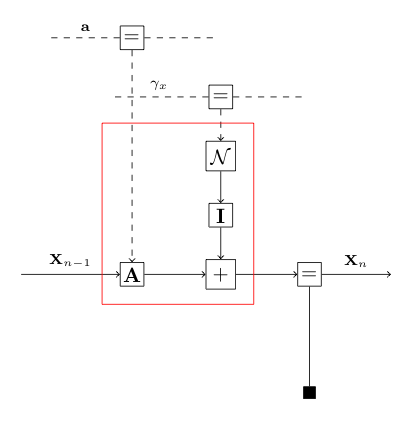

In [17]:
using Images
img = load("../ffgs/AR-online.png")

We are interested in a joint estimation of the AR coefficients $\mathbf{a}$, the precision  of the driving noise $\gamma$

In [18]:
using ForneyLab
using Plots
import ARdata: use_data, generate_data
import LinearAlgebra: I, Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [19]:
function plotter(ma, x, mw, testPoints=100, plt=true)
    from = length(x) - testPoints
    predicted = [ForneyLab.sample(marginals[:a])'x + var(marginals[:w]) for x in x[from-1:end-1]]
    actual = [x[1] for x in x[from:end]]
    mse = (sum((predicted - actual).^2))/length(predicted)
    if plt
        ylims!(-10, 30)
        plot!([actual, predicted], title = "unforeseen data", xlabel="days", ylabel="temperature", label=["actual", "predicted"])
    end
    return mse
end

plotter (generic function with 3 methods)

In [21]:
# Define the order of AR model
ARorder = UInt16(10)
diagAR(dim) = Matrix{Float64}(I, dim, dim)
# Observations and preprocessing
x = use_data("/Users/albertpod/Documents/Julia/VariationalBayes/data/daily-minimum-temperatures.csv", ARorder)
[reverse!(x) for x in x]
x[1:5]

5-element Array{Any,1}:
 [20.0, 21.8, 17.4, 15.8, 15.8, 15.8, 14.6, 18.8, 17.9, 20.7]
 [16.2, 20.0, 21.8, 17.4, 15.8, 15.8, 15.8, 14.6, 18.8, 17.9]
 [13.3, 16.2, 20.0, 21.8, 17.4, 15.8, 15.8, 15.8, 14.6, 18.8]
 [16.7, 13.3, 16.2, 20.0, 21.8, 17.4, 15.8, 15.8, 15.8, 14.6]
 [21.5, 16.7, 13.3, 16.2, 20.0, 21.8, 17.4, 15.8, 15.8, 15.8]

In [22]:
# Building the model
g = FactorGraph()
# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_x_t
@RV w_x_t
@RV a_w_t
@RV b_w_t
@RV m_a_t
@RV w_a_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ GaussianMeanPrecision(m_x_t, w_x_t)
@RV w ~ Gamma(a_w_t, b_w_t)
Autoregression(x_t, x_t_prev, a, w)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_x_t, :m_x_t, dims=(ARorder,))
placeholder(w_x_t, :w_x_t, dims=(ARorder, ARorder))
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8715568932072062583 -->
 
 8715568932072062583 
 
 placeholder_m_x_t 
 
<!-- 8201139082342129065 -->
 
 8201139082342129065 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 8715568932072062583--8201139082342129065 -->
 
 8715568932072062583--8201139082342129065 
 
 m_x_t 
 2 m 
 1 out 
 
<!-- 17688476336851128558 -->
 
 17688476336851128558 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 12474468317470763320 -->
 
 12474468317470763320 
 
 AR 
 autoregression_1 
 
<!-- 12474468317470763320--17688476336851128558 -->
 
 12474468317470763320--17688476336851128558 
 
 a 
 1 out 
 3 a 
 
<!-- 15279085036227116667 -->
 
 15279085036227116667 
 
 Gam 
 gamma_1 
 
<!-- 12474468317470763320--15279085036227116667 -->
 
 12474468317470763320--15279085036227116667 
 
 w 
 1 out 
 4 W 
 
<!-- 12474468317470763320--8201139082342129065 -->
 
 12474468317470763320--8201139082342129065 
 
 x_t 
 1 out 
 1 out 
 
<!-- 8564349112226355387 -->
 
 8564349112226355387 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 12474468317470763320--8564349112226355387 -->
 
 12474468317470763320--8564349112226355387 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 7261016774146427965 -->
 
 7261016774146427965 
 
 placeholder_b_w_t 
 
<!-- 7261016774146427965--15279085036227116667 -->
 
 7261016774146427965--15279085036227116667 
 
 b_w_t 
 3 b 
 1 out 
 
<!-- 2237345309819975821 -->
 
 2237345309819975821 
 
 placeholder_w_a_t 
 
<!-- 2237345309819975821--17688476336851128558 -->
 
 2237345309819975821--17688476336851128558 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 11837566326533688448 -->
 
 11837566326533688448 
 
 placeholder_m_a_t 
 
<!-- 11837566326533688448--17688476336851128558 -->
 
 11837566326533688448--17688476336851128558 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 6204754326253629838 -->
 
 6204754326253629838 
 
 placeholder_m_x_t_prev 
 
<!-- 6204754326253629838--8564349112226355387 -->
 
 6204754326253629838--8564349112226355387 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 2924284956442633581 -->
 
 2924284956442633581 
 
 placeholder_a_w_t 
 
<!-- 2924284956442633581--15279085036227116667 -->
 
 2924284956442633581--15279085036227116667 
 
 a_w_t 
 2 a 
 1 out 
 
<!-- 9287515987546363781 -->
 
 9287515987546363781 
 
 placeholder_w_x_t 
 
<!-- 9287515987546363781--8201139082342129065 -->
 
 9287515987546363781--8201139082342129065 
 
 w_x_t 
 3 w 
 1 out 
 
<!-- 3109275301117073211 -->
 
 3109275301117073211 
 
 placeholder_w_x_t_prev 
 
<!-- 3109275301117073211--8564349112226355387 -->
 
 3109275301117073211--8564349112226355387 
 
 w_x_t_prev 
 3 w 
 1 out

In [23]:
# Specify recognition factorization
q = RecognitionFactorization(a, w, ids=[:A, :W])
# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
# Load algorithms
eval(Meta.parse(algo));

RecognitionFactor[RecognitionFactor(:A, Set(Variable[Variable(:a, Edges:
Edge belonging to variable a: ( gaussianmeanprecision_1.i[out] )----( autoregression_1.i[a] ).
)]), Set(ForneyLab.Cluster[]), Edges:
Edge belonging to variable a: ( gaussianmeanprecision_1.i[out] )----( autoregression_1.i[a] ).
)]
FactorNodes:
GaussianMeanPrecision with id gaussianmeanprecision_1
Autoregression with id autoregression_1

Symbol[:A, :agaussianmeanprecision_1bplaceholder_m_a_t, :agaussianmeanprecision_1bplaceholder_w_a_t]
Symbol[:agaussianmeanprecision_3bautoregression_1, :agaussianmeanprecision_2bautoregression_1, :A, :W]
1.	NaiveVariationalRule{GaussianMeanPrecision} on Interface 1 (out) of GaussianMeanPrecision gaussianmeanprecision_1
2.	NaiveVariationalRule{Autoregression} on Interface 3 (a) of Autoregression autoregression_1

RecognitionFactor[RecognitionFactor(:W, Set(Variable[Variable(:w, Edges:
Edge belonging to variable w: ( gamma_1.i[out] )----( autoregression_1.i[W] ).
)]), Set(ForneyLab.C

In [24]:
# Define values for prior statistics
m_x_prev_0 = x[1]
w_x_prev_0 = (huge*diagAR(ARorder))
m_x_0 = x[2]
w_x_0 = (huge*diagAR(ARorder))
a_w_0 = 20
b_w_0 = 2
m_a_0 = 5.0*rand(ARorder)
w_a_0 = (0.25*diagAR(ARorder));

In [25]:
# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(x))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(x))
m_x = Vector{Vector{Float64}}(undef, length(x))
w_x = Vector{Array{Float64, 2}}(undef, length(x))
a_w = Vector{Float64}(undef, length(x))
b_w = Vector{Float64}(undef, length(x))
m_a = Vector{Vector{Float64}}(undef, length(x))
w_a = Vector{Array{Float64, 2}}(undef, length(x))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_x_t_min = m_x_0
w_x_t_min = w_x_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [26]:
marginals = Dict()
n_its = 10
# Number of points for test set
testPoints = 100
# Storage for MSE for test set
MSEs = [];

In [27]:
anim = @animate for t = 2:length(x)-testPoints
    s = plot()
    #println("Observation # ", t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_min, w=w_x_t_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    for i = 1:n_its
        #println("Iteration # ", i)
        global m_x_t_prev_min, w_x_t_prev_min, m_x_t_min, w_x_t_min,
               a_w_t_min, b_w_t_min, m_a_t_min, w_a_t_min

        data = Dict(:m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :m_x_t => m_x_t_min,
                    :w_x_t => w_x_t_min,
                    :a_w_t => a_w_t_min,
                    :b_w_t => b_w_t_min)
        stepA!(data, marginals)
        stepW!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = (huge*diagAR(ARorder))
        m_x_prev[t] = unsafeMean(marginals[:x_t_prev])
        w_x_prev[t] = (huge*diagAR(ARorder))
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = x[t]
        w_x_t_prev_min = w_x_prev[t]
        m_x_t_min = x[t+1]
        w_x_t_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    mse = plotter(marginals[:a], x, marginals[:w], testPoints, true)
    #display(mse)
    push!(MSEs, mse);
end;

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmpN5QAS9", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "003527.png", "003528.png", "003529.png", "003530.png", "003531.png", "003532.png", "003533.png", "003534.png", "003535.png", "003536.png"])

In [41]:
gif(anim, "../gifs/AR-online.gif", fps = 1)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-online.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-online.gif")

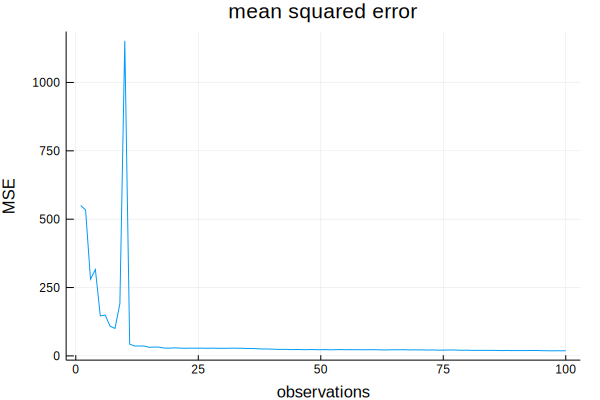

In [39]:
plot(MSEs[1:100], title="mean squared error", xlabel="observations", ylabel="MSE", legend=false)